In [1]:


## 1. 定义模型
import torch.nn as nn
from transformers import BertModel, BertTokenizer
class BertClassifier(nn.Module):
    def __init__(self, bert_config, num_labels):
        super().__init__()
        # 定义BERT模型
        self.bert = BertModel(config=bert_config)
        # 定义分类器
        self.classifier = nn.Linear(bert_config.hidden_size, num_labels)
        
    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs[1]
        logits = self.classifier(pooled_output)
        return logits
    
    
class BertLstmClassifier(nn.Module):
    def __init__(self, bert_config, num_labels):
        super().__init__()
        self.bert = BertModel(config=bert_config)
        self.lstm = nn.LSTM(bert_config.hidden_size, bert_config.hidden_size, num_layers=2,batch_first=True, bidirectional=True)
        self.classifier = nn.Linear(bert_config.hidden_size * 2, num_labels) ## 双向LSTM
        
    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        sequence_output = outputs.last_hidden_state
        lstm_output, _ = self.lstm(sequence_output)
        logits = self.classifier(lstm_output[:, -1, :])
        return logits
    


In [2]:
from torch.utils.data import Dataset
import json
import numpy as np
import torch
import sys


class _2012Dataset(Dataset):
    def __init__(self, file_path, tokenizer, max_length=1024,is_dynamic_max_length=True):
        self.lib_labels = [
            "Touched",
            "Sympathy",
            "Bored",
            "Angry",
            "Funny",
            "Sad",
            "Novel",
            "Warm",
        ]
        self.label_to_id = {label: i for i, label in enumerate(self.lib_labels)}
        self.id_to_label = {i: label for i, label in enumerate(self.lib_labels)}
        self.tokenizer = tokenizer
        self.input_ids = []
        self.attention_mask = []
        self.token_type_ids = []
        self.label_scores = []
        self.max_length = max_length
        self.load_data(file_path,is_dynamic_max_length)
        
        
    def load_data(self, file_path,is_dynamic_max_length):
        with open(file_path, "r", encoding="utf-8") as f:
            data = json.load(f)
        if(is_dynamic_max_length):
            for item in data:
                text = item["news"].replace(" ", "")
                self.max_length = min(512,max(self.max_length, len(text)))
        for item in data:
            text = item["news"].replace(" ", "")  # 移除空格
            # 提取情感值并转换为整数
            emotions = {k: int(v) for k, v in item.items() if k in self.lib_labels}
            total = int(item["Total"])  # 确保 Total 也转换为整数

            # 情感强度归一化
            if total > 0:
                label_vector = [emotions[label] / total for label in self.lib_labels]
            else:
                label_vector = [0.0] * len(self.lib_labels)  # 如果 Total 为 0，所有情感归为 0

            # Tokenization
            token = self.tokenizer(
                text,
                max_length=self.max_length,
                add_special_tokens=True,
                padding="max_length",
                truncation=True,
                return_tensors="pt",
            )
            self.input_ids.append(token["input_ids"].clone().detach())
            self.attention_mask.append(token["attention_mask"].clone().detach())
            self.token_type_ids.append(token["token_type_ids"].clone().detach())
            self.label_scores.append(torch.tensor(label_vector, dtype=torch.float))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return (
            self.input_ids[idx].squeeze(0),
            self.attention_mask[idx].squeeze(0),
            self.token_type_ids[idx].squeeze(0),
            self.label_scores[idx],
        )
        
        
tokenizer = BertTokenizer.from_pretrained('model/bert-base-chinese')  # 替换为适合的 tokenizer 路径
test_data = _2012Dataset('data/2012.json', tokenizer)
print("数据集长度:", len(test_data))
input_ids, attention_mask, token_type_ids, label_scores = test_data[2]

# 解码文本
decoded_text = tokenizer.decode(input_ids.tolist(), skip_special_tokens=True)
print("解码后的文本:", decoded_text)
print("情感强度向量:", label_scores.numpy())

# 输出对应情感标签和归一化值
print("情感标签及归一化值:")
for i, score in enumerate(label_scores.numpy()):
    print(f"{test_data.id_to_label[i]}: {score:.4f}")
    
    
print("数据加载成功...", file=sys.stderr)


数据集长度: 4570
解码后的文本: 男 子 婚 房 房 贷 抢 劫 彩 票 店 本 报 记 者 赵 云 龙 2011 年 12 月 28 日 晚 10 时 17 分 许 水 屯 路 南 段 福 彩 投 注 站 女 老 板 林 丽 化 名 整 理 钱 款 欲 关 门 回 家 低 头 收 拾 时 男 子 突 然 快 步 走 进 店 里 手 持 红 色 形 锁 隔 柜 台 头 部 猛 砸 过 去 砸 两 下 后 男 子 绕 进 柜 台 内 侧 林 丽 连 砸 下 柜 台 两 提 包 抢 走 砸 完 跑 店 门 店 里 一 个 椅 子 追 四 五 米 骑 摩 托 车 跑 林 丽 告 诉 记 者 砸 后 头 部 留 下 处 伤 口 缝 20 多 针 抢 走 两 包 里 13000 余 元 现 金 一 些 银 行 存 折 部 分 刮 刮 乐 彩 票 案 发 后 调 取 监 控 录 像 警 方 很 快 掌 握 嫌 疑 人 体 貌 特 征 本 报 2011 年 12 月 30 日 刊 发 深 夜 抢 彩 票 站 狂 砸 女 老 板 文 显 示 嫌 疑 人 清 晰 面 容 监 控 截 图 刊 登 希 望 读 者 提 供 相 关 破 案 线 索 警 媒 联 动 下 2011 年 12 月 30 日 下 午 2 时 许 热 心 市 民 警 方 提 供 条 重 要 线 索 嫌 疑 人 居 住 梁 府 庄 一 带 民 警 梁 府 庄 犯 罪 嫌 疑 人 向 某 抓 获 缴 获 抢 劫 13000 余 元 现 金 银 行 存 折 刮 刮 乐 彩 票 物 今 年 30 岁 已 失 业 许 久 2 年 前 结 婚 时 曾 妻 子 老 家 泰 安 买 套 婚 房 目 前 尚 万 元 房 贷 春 节 向 某 身 上 钱 房 贷 近 期 一 直 为 难 2011 年 12 月 28 日 晚 6 时 向 某 朋 友 东 关 大 街 酒 店 吃 饭 席 间 喝 五 六 瓶 啤 酒 消 愁 饭 局 结 束 后 向 某 回 家 途 中 想 买 彩 票 碰 碰 运 气 当 晚 10 时 09 分 走 进 水 屯 路 南 段 福 彩 投 注 站 告 知 开 奖 时 间 已 结 束 该 店 关 门 无 意 间 向 某 看 到 该 店 女 老 板 林 丽 正 在 清 点 钱 款 萌 生 抢 劫 念 头 盯 林 丽 

数据加载成功...


In [3]:
#分割数据集
import json
import random

# 加载原始数据集
with open('data/2012.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

# 打乱数据集
random.shuffle(data)

# 分割数据集
split_index = int(len(data) * 0.8)
train_data = data[:split_index]
test_data = data[split_index:]

# 保存训练集到 train.json
with open('data/train.json', 'w', encoding='utf-8') as train_file:
    json.dump(train_data, train_file, ensure_ascii=False, indent=4)

# 保存测试集到 test.json
with open('data/test.json', 'w', encoding='utf-8') as test_file:
    json.dump(test_data, test_file, ensure_ascii=False, indent=4)

print(f"训练集大小: {len(train_data)}")
print(f"测试集大小: {len(test_data)}")

训练集大小: 3656
测试集大小: 914


In [4]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from scipy.stats import pearsonr

def train(
    model,
    train_dataset,
    val_dataset,
    epochs=10,
    batch_size=5,
    learning_rate=2e-5,
    weight_decay=1e-4,  # 添加权重衰减
    patience=3,  # 提前停止的容忍度
    device="cuda" if torch.cuda.is_available() else "cpu",
):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    loss_fn = nn.MSELoss()
    model.to(device)

    train_losses = []
    train_accuracies = []
    train_pearsons = []
    val_accuracies = []
    val_pearsons = []

    best_val_loss = float('inf')
    early_stop_counter = 0

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        pearson_sum = 0
        pearson_count = 0

        for batch in train_loader:
            input_ids, attention_mask, token_type_ids, label_scores = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            label_scores = label_scores.to(device)

            optimizer.zero_grad()

            logits = model(input_ids, attention_mask, token_type_ids)
            loss = loss_fn(logits, label_scores)
            train_loss += loss.item()

            loss.backward()
            optimizer.step()

            _, pred = torch.max(logits, dim=1)
            _, truth = torch.max(label_scores, dim=1)
            correct += (pred == truth).sum().item()
            total += label_scores.size(0)

            for i in range(logits.size(0)):
                pearson, _ = pearsonr(logits[i].cpu().detach().numpy(), label_scores[i].cpu().detach().numpy())
                pearson_sum += pearson
                pearson_count += 1

        train_accuracy = correct / total
        avg_train_loss = train_loss / len(train_loader)
        avg_pearson = pearson_sum / pearson_count

        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)
        train_pearsons.append(avg_pearson)

        print(f"Train Loss={avg_train_loss:.4f}, Train Accuracy={train_accuracy:.4f}, Train Pearson={avg_pearson:.4f}")

        # 验证阶段
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        pearson_sum = 0
        pearson_count = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids, attention_mask, token_type_ids, label_scores = batch
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                token_type_ids = token_type_ids.to(device)
                label_scores = label_scores.to(device)

                logits = model(input_ids, attention_mask, token_type_ids)
                loss = loss_fn(logits, label_scores)
                val_loss += loss.item()

                _, pred = torch.max(logits, dim=1)
                _, truth = torch.max(label_scores, dim=1)
                correct += (pred == truth).sum().item()
                total += label_scores.size(0)

                for i in range(logits.size(0)):
                    pearson, _ = pearsonr(logits[i].cpu().numpy(), label_scores[i].cpu().numpy())
                    pearson_sum += pearson
                    pearson_count += 1

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = correct / total
        avg_pearson = pearson_sum / pearson_count

        val_accuracies.append(val_accuracy)
        val_pearsons.append(avg_pearson)

        print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Validation Pearson: {avg_pearson:.4f}")

        # 提前停止逻辑
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print("Early stopping triggered.")
                break

    print("Training Complete")

    return train_losses, train_accuracies, train_pearsons, val_accuracies, val_pearsons


Epoch 1/10
Train Loss=0.0485, Train Accuracy=0.4097, Train Pearson=0.3516
Validation Loss: 0.0442, Validation Accuracy: 0.4409, Validation Pearson: 0.4095
Epoch 2/10
Train Loss=0.0434, Train Accuracy=0.4461, Train Pearson=0.3980
Validation Loss: 0.0390, Validation Accuracy: 0.4573, Validation Pearson: 0.4220
Epoch 3/10
Train Loss=0.0379, Train Accuracy=0.5129, Train Pearson=0.4862
Validation Loss: 0.0367, Validation Accuracy: 0.5109, Validation Pearson: 0.5149
Epoch 4/10
Train Loss=0.0340, Train Accuracy=0.5514, Train Pearson=0.5484
Validation Loss: 0.0312, Validation Accuracy: 0.5602, Validation Pearson: 0.5612
Epoch 5/10
Train Loss=0.0298, Train Accuracy=0.5878, Train Pearson=0.6151
Validation Loss: 0.0297, Validation Accuracy: 0.5711, Validation Pearson: 0.5933
Epoch 6/10
Train Loss=0.0268, Train Accuracy=0.6152, Train Pearson=0.6526
Validation Loss: 0.0311, Validation Accuracy: 0.5810, Validation Pearson: 0.6030
Epoch 7/10
Train Loss=0.0233, Train Accuracy=0.6482, Train Pearson=0.6

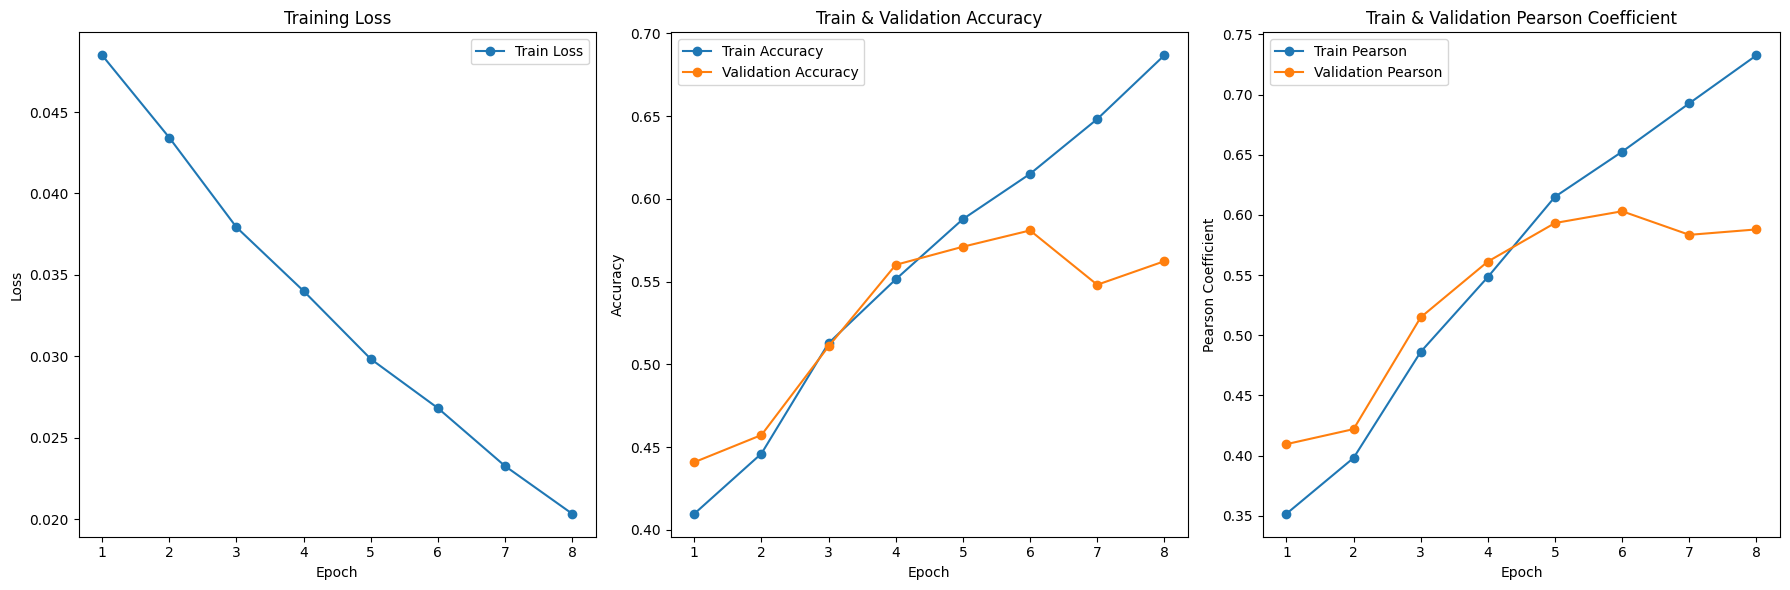

In [5]:
import matplotlib.pyplot as plt
from transformers import BertConfig, BertTokenizer

tokenizer = BertTokenizer.from_pretrained('model/bert-base-chinese')  
model = BertClassifier(BertConfig.from_pretrained('model/bert-base-chinese'), num_labels=8)  
train_dataset = _2012Dataset('data/train.json', tokenizer)
val_dataset = _2012Dataset('data/test.json', tokenizer)
# 调用训练函数
train_losses, train_accuracies, train_pearsons, val_accuracies, val_pearsons = train(
    model, 
    train_dataset, 
    val_dataset, 
    epochs=10, 
    batch_size=5, 
    learning_rate=2e-5
)

# 绘制训练过程中的 Loss、Accuracy 和 Pearson Coefficient 曲线
plt.figure(figsize=(18, 6))

# Loss 曲线
plt.subplot(1, 3, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

# Accuracy 曲线
plt.subplot(1, 3, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Train Accuracy", marker="o")
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Validation Accuracy", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train & Validation Accuracy")
plt.legend()

# Pearson Coefficient 曲线
plt.subplot(1, 3, 3)
plt.plot(range(1, len(train_pearsons) + 1), train_pearsons, label="Train Pearson", marker="o")
plt.plot(range(1, len(val_pearsons) + 1), val_pearsons, label="Validation Pearson", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Pearson Coefficient")
plt.title("Train & Validation Pearson Coefficient")
plt.legend()

plt.tight_layout()
plt.show()
